# AGLAE PIGE data treatment

In [6]:
%pip install ipywidgets xlrd matplotlib

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [7]:
import bae
import ipywidgets as widgets
from ipywidgets import interact, interactive, fixed, interact_manual
import io
import pandas as pd
from pandas.api.typing import DataFrameGroupBy
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.font_manager

SMALL_SIZE = 10
MEDIUM_SIZE = 14
BIGGER_SIZE = 16

plt.rc('font', size=BIGGER_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=BIGGER_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=BIGGER_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=BIGGER_SIZE)    # legend fontsize
plt.rc('figure', titlesize=MEDIUM_SIZE)  # fontsize of the figure title


# Upload de fichier

In [9]:
uploader_report = widgets.FileUpload(description="rapport d'analyses")
uploader_pige_sodium = widgets.FileUpload(description="données PIGE Na", accept=".txt", style={'description_width': 'initial'})
uploader_pixe = widgets.FileUpload(description="données PIXE")
has_bore_w = widgets.Checkbox(
    value=False,
    description='A du bore ?',
    disabled=False,
    indent=False
)

display(uploader_report)
display(uploader_pige_sodium)

# TODO: ajouter autre bouton quand y'a du bore
display(has_bore_w)
display(uploader_pixe)

FileUpload(value=(), description="rapport d'analyses")

FileUpload(value=(), accept='.txt', description='données PIGE Na')

Checkbox(value=False, description='A du bore ?', indent=False)

FileUpload(value=(), description='données PIXE')

In [211]:
print(uploader_report.value)
print(uploader_pige_sodium.value)
print(uploader_pixe.value)

# l'index des trois tableaux sera le nom du fichier (sans extension)
report = pd.read_excel(io.BytesIO(uploader_report.value[0].content), index_col=0)
pige_table = pd.read_csv(io.BytesIO(uploader_pige_sodium.value[0].content), sep="\t", index_col=0)
# on enleve "g7" pour avoir le meme index dans tous les tableaux pour facilement faire des jointures
pige_table.index = pige_table.index.str.replace('.g7', '', regex=False)
pixe_table = pd.read_excel(io.BytesIO(uploader_pixe.value[0].content),sheet_name="S_Conc. ppm", header=1, index_col=0)

print(pixe_table.columns)


({'name': 'Rapport_1_20240618_EMMA_IBA.xls', 'type': 'application/vnd.ms-excel', 'size': 117248, 'content': <memory at 0x0000017367343940>, 'last_modified': datetime.datetime(2025, 1, 12, 17, 41, 2, 73000, tzinfo=datetime.timezone.utc)},)
({'name': 'emma_pige_Na.txt', 'type': 'text/plain', 'size': 11942, 'content': <memory at 0x0000017367343700>, 'last_modified': datetime.datetime(2025, 1, 10, 16, 21, 40, 223000, tzinfo=datetime.timezone.utc)},)
({'name': 'emma_pixe.xlsx', 'type': 'application/vnd.openxmlformats-officedocument.spreadsheetml.sheet', 'size': 809877, 'content': <memory at 0x0000017305280280>, 'last_modified': datetime.datetime(2025, 1, 13, 16, 58, 32, 758000, tzinfo=datetime.timezone.utc)},)
Index(['Unnamed: 1', 'Na2O', 'MgO', 'Al2O3', 'SiO2', 'P2O5', 'SO3', 'Cl',
       'K2O', 'CaO', 'TiO2', 'V2O3', 'Cr2O3', 'MnO', 'Fe2O3', 'CoO', 'NiO',
       'CuO', 'ZnO', 'As2O5', 'SeO2', 'Br', 'Rb2O', 'SrO', 'Y2O3', 'ZrO2',
       'Ag2O', 'SnO2', 'Sb2O5', 'BaO', 'Au2O3', 'HgO', 'PbO'

# On garde les tableaux avec uniquement les standards

In [212]:
pige_table["A/D"] = pige_table["Aire Gaussien"]/report["Dose"]

stds = pd.DataFrame(
    {
         "Ref Objet": ["BrillA", "BrillB", "BrillC", "BrillD", "BG4", "BG3"],
         "Conc theorique": [143900, 172600, 12000, 10700, 50000, 75000],
    }
)
conc_stds_sans_plomb = stds[stds["Ref Objet"].isin(["BrillA","BrillB","BrillD"])]
conc_stds_avec_plomb = stds[stds["Ref Objet"].isin(["BrillC","BG4","BG3"])]

report_stds = report[report["Ref Objet"].isin(stds["Ref Objet"])]

# on veut prendre que les standards dans le nom du fichier, on fait ca en appelant contains en mode regex avec tous les standards (séparés par des "ou", i.e. la barre '|')
pige_stds = pige_table[pige_table.index.str.contains("|".join(stds["Ref Objet"]), regex=True)].copy()

# On vérifie que le nombre de standards dans le rapport et dans PIGE est le même
print(f"On a {len(report_stds)} standards dans le rapport d'analyses")
print(f"On a {len(pige_stds)} standards dans les données PIGE Na")

On a 43 standards dans le rapport d'analyses
On a 43 standards dans les données PIGE Na


# Droite de calibration

- On trace la droite de calibration PIGE $\Large c = k \times \frac{A}{D}$ avec:
  - $c$ la concentration théorique du sodium dans les standards
  - $k$ la pente déterminée par méthode des moindres carrés ordinaires.
  - $A$ l'aire gaussienne
  - $D$ la dose


On définit d'abord la fonction CALIB

In [264]:
# Fonction qui va afficher les courbes de calibration et son fit linéaire par méthode des moindres carrés ordinaires
def calib(titre, ads, conc, axe):
    axe.set_title(titre)
    axe.set_xlabel("Aire / Dose (u.a.)")
    axe.set_ylabel("Concentration théorique (ppm)")
    axe.grid(True)
    colors = ["blue", "red"]
    coefs = []
    align = ["bottom", "top"]
    
    # On affiche toutes les droites de calibration
    for i, df in enumerate(ads):
        # il peut y avoir plusieures prises de standards, on les aggrège dans une liste
        ad_stds = df.groupby("Ref Objet")["A/D"].agg(list)
        
        # Au lieu de fitter chaque standard séparément,
        # on va collecter tous les points (x, y) de ce DataFrame
        all_x = []
        all_y = []
        for std, x_vals in ad_stds.items():
            # x est déjà une liste, on passe en array NumPy
            x_vals = np.array(x_vals, dtype=float)
            
            # on ne prend que les valeurs theoriques pour lesquelles on a fait une prise experimentale
            subset_conc = conc[conc["Ref Objet"] == std]["Conc theorique"]
            if subset_conc.empty:
                # Cas où la référence std n'existe pas dans conc
                print(f"Attention : std '{std}' pas trouvé dans conc.")
                continue

            y_val = subset_conc.iloc[0]
            y_vals = np.full_like(x_vals, y_val)
            axe.plot(x_vals, y_vals, '.', label=f"{std} {'init' if i == 0 else 'fin'}", markersize=12, color=colors[i % len(colors)]) 
            
            # On stocke les points dans nos listes globales
            all_x.extend(x_vals)
            all_y.extend(y_vals)


         # Si on a recueilli au moins 2 points pour faire un fit
        if len(all_x) > 1:
            all_x = np.array(all_x, dtype=float)
            all_y = np.array(all_y, dtype=float)

            # Régression forcée à l'origine : y = a * x
            # => X = all_x.reshape(-1,1), Y = all_y
            a_coef, _, _, _ = np.linalg.lstsq(all_x.reshape(-1, 1), all_y, rcond=None)
            a = a_coef[0]
            coefs.append(a)

            # Calcul du y_pred
            y_pred = a * all_x

            ## Calcul du R² classique
            #ss_res = np.sum((all_y - y_pred)**2)
            #ss_tot = np.sum((all_y - all_y.mean())**2)
            #if ss_tot == 0:
             #   r_squared = np.nan
            #else:
             #   r_squared = 1 - (ss_res / ss_tot)

            # Calcul du R² no-intercept (style Excel)
            ss_res = np.sum((all_y - y_pred)**2)
            ss_tot_no_intercept = np.sum(all_y**2)
            r_squared = 1 - ss_res/ss_tot_no_intercept

            # Tracé de la droite
            x_sorted = np.sort(all_x)
            y_pred_sorted = a * x_sorted

            axe.plot(
                x_sorted, 
                y_pred_sorted, 
                linestyle="--",
                color=colors[i % len(colors)],
                #label=f"Droite {i}: y={a:.2f}x\nR²={r_squared:.3f}"
            )

            x_min, x_max = np.min(all_x), np.max(all_x)
            # Calcul du point "milieu" pour y mettre le texte
            mid_x = 0.5 * (x_min + x_max) - 0.01
            mid_y = a * mid_x
        
            # Angle de la pente en degrés (pour faire pivoter le texte)
            #angle = np.degrees(a) / 1000000
            angle = np.degrees(np.arctan(a))
            
            # Ajout du texte sur la droite
            axe.text(
                mid_x, mid_y,               # Coordonnées où placer le texte
                f"y = {a:.2f} x\nR²={r_squared:.4f}",           # Contenu du texte (équation)
                rotation=angle,            # Rotation pour suivre la pente
                ha="left", va=align[i % len(align)],  # Alignement horizontal/vertical du texte
                rotation_mode="anchor",
                transform_rotates_text=True,
                fontsize=BIGGER_SIZE,
            )
                
    axe.legend(loc='best', fontsize=10)
    return coefs

Pour chaque jour d'expériences, on trace les différentes droites de calibration pour les standards avec ou sans plomb, et en mettant sur le même plot la droite du matin et celle du soir.
On corrige la déviation des droites de calibration entre matin et soir par une régression linéaire en fonction de l'heure de mesure.
Pour cela on fait la moyenne des durées d'acquisition des standards avec ou sans plomb pour obtenir $t1$ (matin) et $t2$ (soir)
Puis on calcule $k(t) = \frac{k2-k1}{t2-t1}$ avec $k1$ et $k2$ la pente extraite des droites de calibration le matin et le soir

In [265]:
# Fonction qui sert à convertir la durée d'acquisition des standards en secondes 
def timestamp_total_seconds(ts):
    return  ts.hour * 3600 + ts.minute * 60 + ts.second
    

Taille de report_pige_pixe: 157
Taille de Na_conc_df: 157


,Ref Objet,PbO,Time,A/D,k(t) sans plomb,k(t) avec plomb,Na2O PIGE
File N°,,,,,,,
20240618_0001_BrillA_EMMA_IBA,BrillA,852,2024-06-18 09:52:36,0.286953,406998.654260,NaN,116789.294358
20240618_0002_BrillB_EMMA_IBA,BrillB,6310,2024-06-18 09:59:17,0.348847,408447.630611,NaN,NaN
20240618_0003_BrillC_EMMA_IBA,BrillC,438600,2024-06-18 10:06:18,0.029525,NaN,346383.285248,10227.057421
20240618_0004_BG4_EMMA_IBA,BG4,352700,2024-06-18 10:12:44,0.144972,NaN,346928.655727,50294.851319
20240618_0005_BG3_EMMA_IBA,BG3,122000,2024-06-18 10:17:57,0.182018,NaN,347370.886194,63227.922088
20240618_0006_BrillA_EMMA_IBA,BrillA,847,2024-06-18 10:39:26,0.272914,417152.328938,NaN,113846.722439
20240618_0007_BrillB_EMMA_IBA,BrillB,5750,2024-06-18 11:07:54,0.332330,423324.028706,NaN,NaN
20240618_0009_Cl-23920_EMMA_IBA,Cl-23920,62690,2024-06-18 11:47:51,0.091547,NaN,NaN,NaN
20240618_0010_Cl-23920_EMMA_IBA,Cl-23920,59150,2024-06-18 11:55:10,0.088722,NaN,NaN,NaN


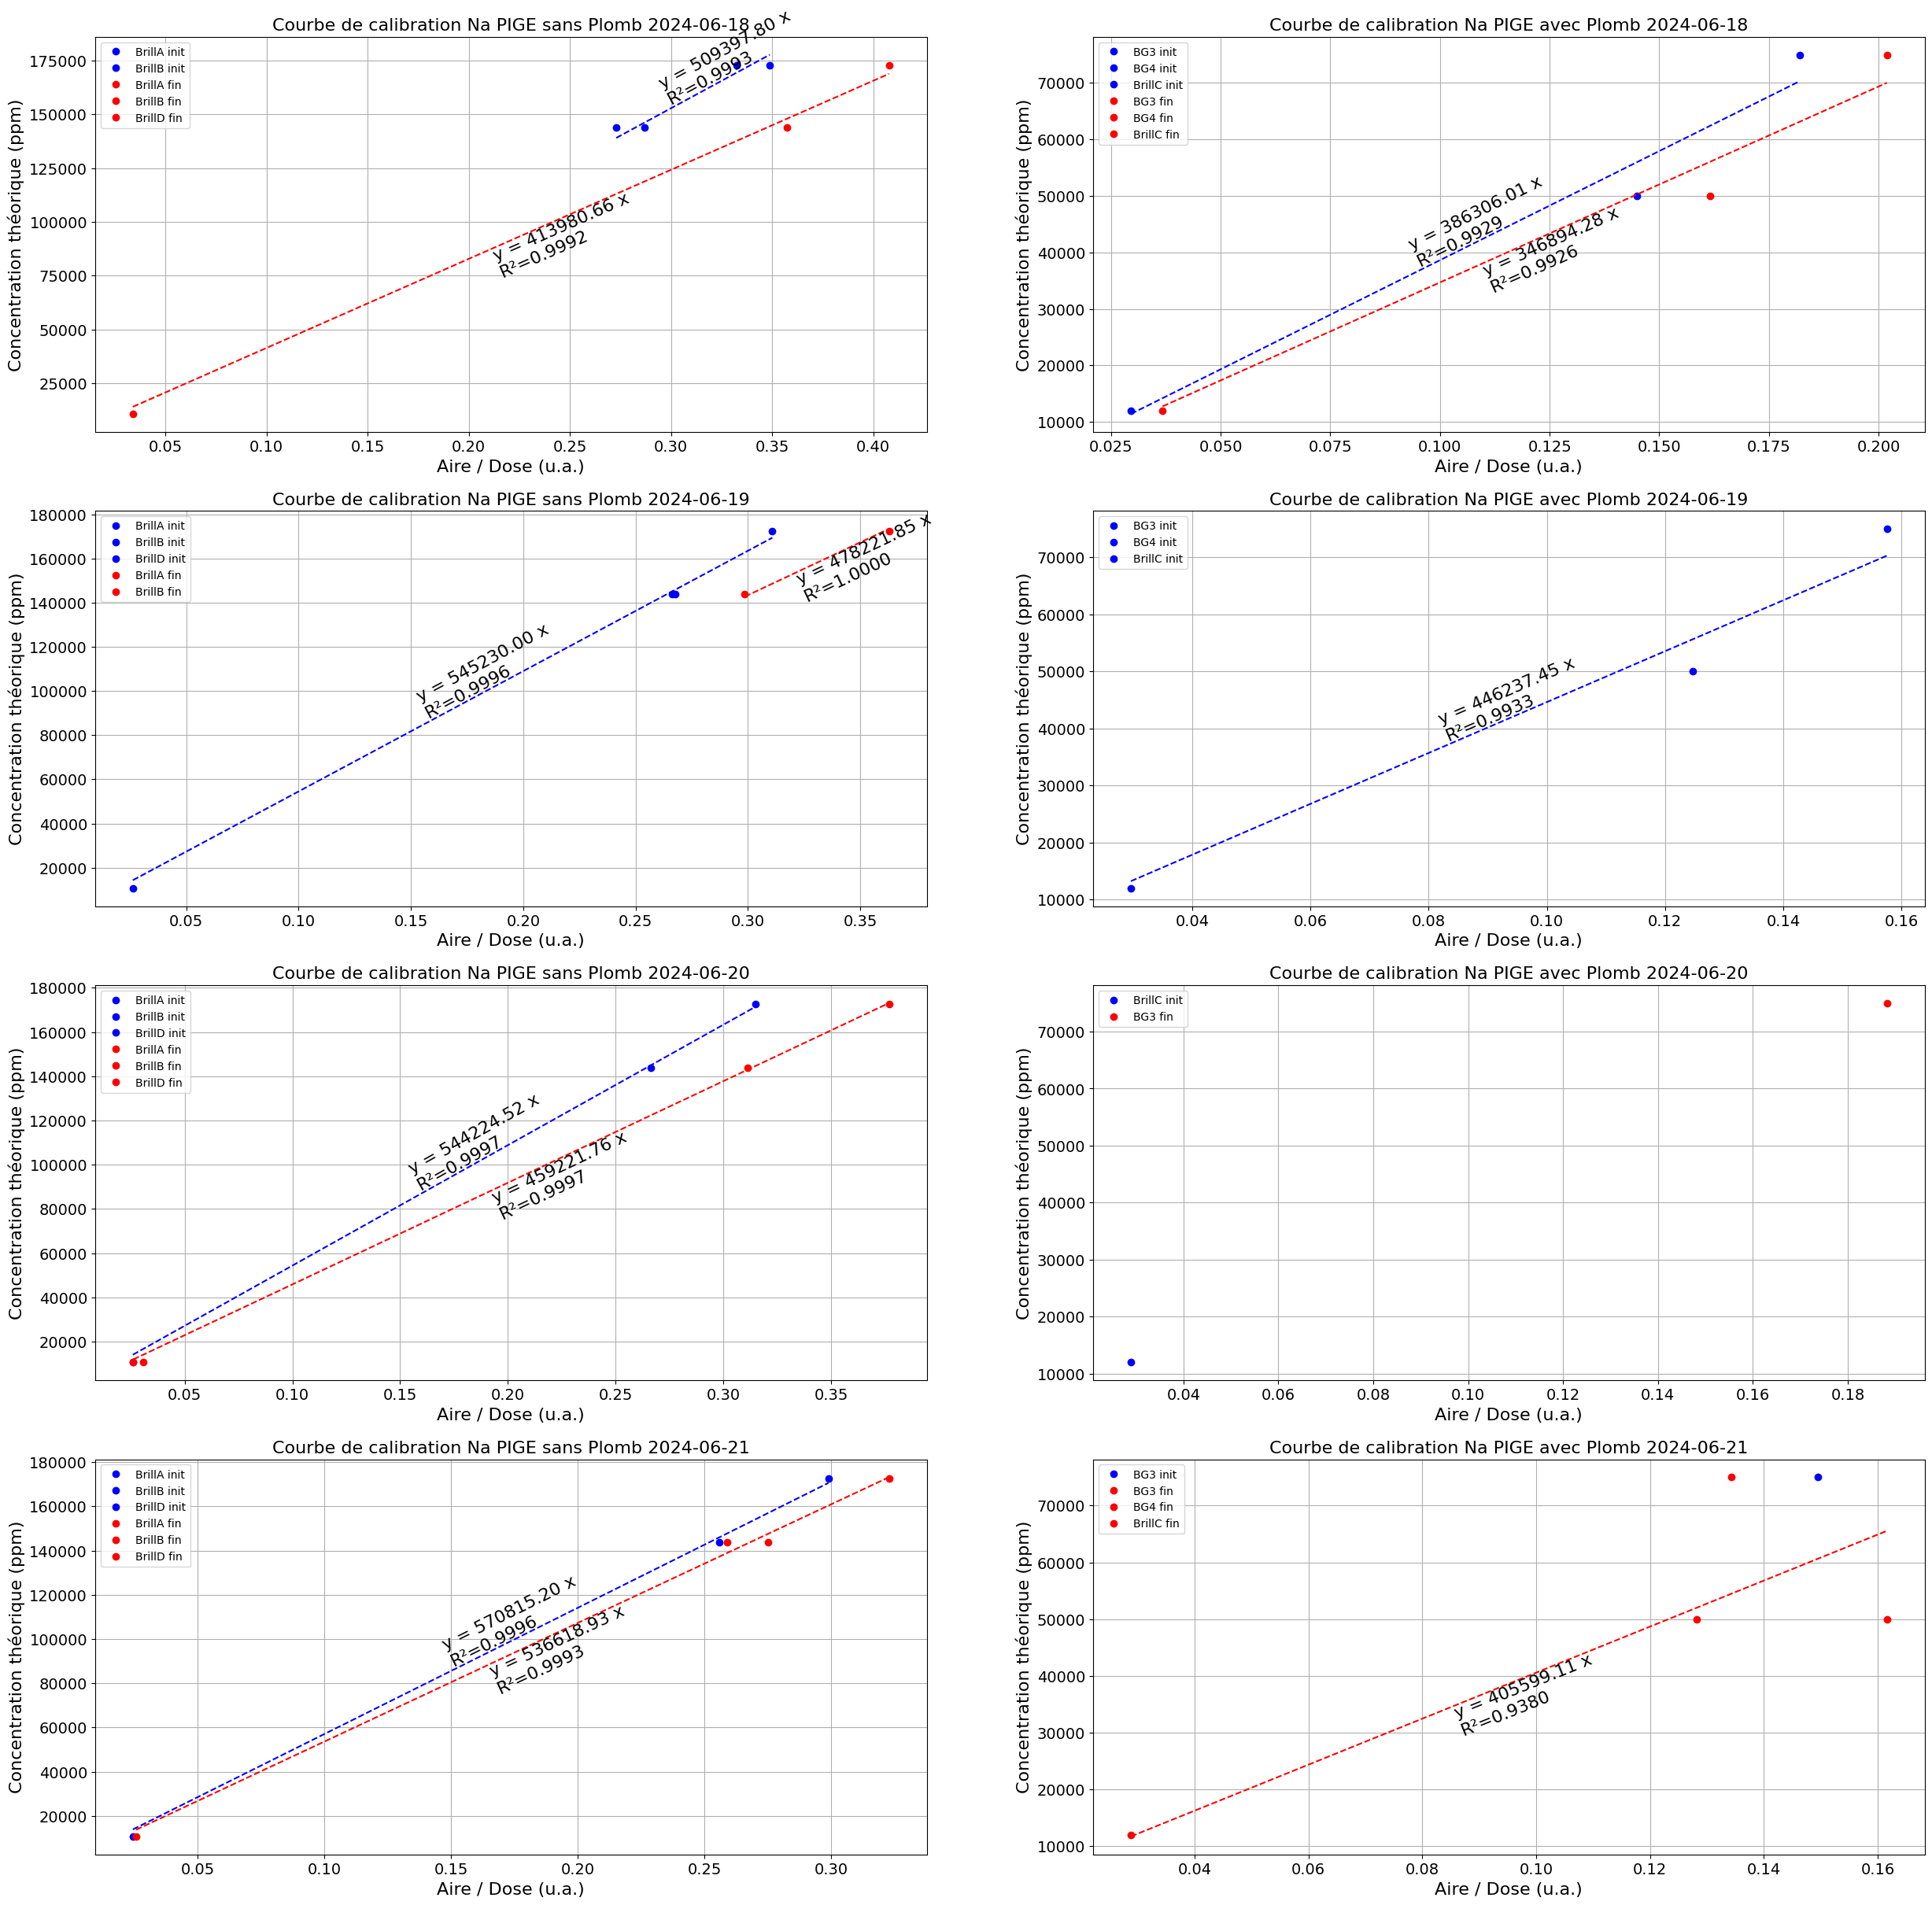

In [266]:
# On fusionne les trois documents Rapport, PIGE et PIXE 
report_pige_pixe = report.join([pige_table,pixe_table])

# On calcule le nombre de lignes dans la planche de plot (nombre de jours de manips)
report_par_jour = report_pige_pixe.groupby(report["Time"].dt.date)

# On trace la planche pour les plots 
fig, axes = plt.subplots(nrows=len(report_par_jour), ncols=2, figsize=(30,30))

Na_conc_df = pd.DataFrame({
        "Ref Objet": report_pige_pixe["Ref Objet"],
        "PbO": report_pige_pixe["PbO"], 
        "Time": report_pige_pixe["Time"],
        "A/D": report_pige_pixe["Aire Gaussien"]/report_pige_pixe["Dose"],
})

# On convertit les valeurs de la colonne PbO en type non convertible et on affiche NaN si pas possible
report_pige_pixe["PbO"] = pd.to_numeric(report_pige_pixe["PbO"], errors = "coerce")

# On vérifie la longueur des dataframes
print("Taille de report_pige_pixe:", len(report_pige_pixe))
print("Taille de Na_conc_df:", len(Na_conc_df))

# On fait une boucle for pour parcourir le rapport jour par jour et extraire les standards avec ou sans plomb
for i, (day, group) in enumerate(report_par_jour):
    time_sans_plomb = []
    time_avec_plomb = []

    # On sépare les standards avec ou sans plomb
    stds_sans_plomb = group[group["Ref Objet"].isin(["BrillA","BrillB","BrillD"])]
    stds_avec_plomb = group[group["Ref Objet"].isin(["BrillC","BG4","BG3"])]
    
    
    # On sépare les standards avant et après midi
    am_data_sans_plomb = stds_sans_plomb[stds_sans_plomb["Time"].dt.hour < 12]
    am_data_avec_plomb = stds_avec_plomb[stds_avec_plomb["Time"].dt.hour < 12]

    pm_data_sans_plomb = stds_sans_plomb[stds_sans_plomb["Time"].dt.hour >= 12]
    pm_data_avec_plomb = stds_avec_plomb[stds_avec_plomb["Time"].dt.hour >= 12]
    
        
    # On trace les droite de calibration et leur fit avec l'équation et le coefficient R
    coefs_sans_plomb = calib(f"Courbe de calibration Na PIGE sans Plomb {day}", [am_data_sans_plomb, pm_data_sans_plomb], conc_stds_sans_plomb, axes[i, 0])
    coefs_avec_plomb = calib(f"Courbe de calibration Na PIGE avec Plomb {day}", [am_data_avec_plomb, pm_data_avec_plomb], conc_stds_avec_plomb, axes[i, 1])

    if len(coefs_sans_plomb) < 2 or len(coefs_avec_plomb) < 2:
        continue


    # On calcule la moyenne des temps de mesure des standards avec ou sans plomb, matin et soir
    
    t_moyen_sans_plomb_init = am_data_sans_plomb["Time"].apply(timestamp_total_seconds).mean()                   
    t_moyen_avec_plomb_init = am_data_avec_plomb["Time"].apply(timestamp_total_seconds).mean()

    t_moyen_sans_plomb_fin = pm_data_sans_plomb["Time"].apply(timestamp_total_seconds).mean()                   
    t_moyen_avec_plomb_fin = pm_data_avec_plomb["Time"].apply(timestamp_total_seconds).mean()

    if pd.isnull(t_moyen_sans_plomb_init) or pd.isnull(t_moyen_avec_plomb_init) or pd.isnull(t_moyen_sans_plomb_fin) or pd.isnull(t_moyen_avec_plomb_fin):
        continue

    # on crée deux dataframe pour stocker les valeurs des temps moyens et des pentes calculées par calib, avec ou sans plomb
    
    times_init =  pd.Series({
        "sans plomb": t_moyen_sans_plomb_init, 
        "avec plomb": t_moyen_avec_plomb_init,
    })
    coefs_init =  pd.Series({
        "sans plomb": coefs_sans_plomb[-1],
        "avec plomb": coefs_avec_plomb[-1],
    })       
    times_fin = pd.Series({
        "sans plomb": t_moyen_sans_plomb_fin, 
        "avec plomb": t_moyen_avec_plomb_fin,
    })
    coefs_fin = pd.Series({
        "sans plomb": coefs_sans_plomb[0],
        "avec plomb": coefs_avec_plomb[0],
    })
    
    # Calcul du coefficient k de régression linéaire de correction d'heures   
    t_diff = times_fin - times_init
    coefs_diff = coefs_fin - coefs_init

    k = coefs_diff / t_diff
    #display(coefs_sans_plomb[0])
    #k_t_sans_plomb = k_sans_plomb * report_pige_pixe["Time"].apply(timestamp_total_seconds) + coefs_sans_plomb[-1] - k_sans_plomb * times_fin["Temps moyen final sans plomb"]
   
    k_t_sans_plomb = k["sans plomb"] * stds_sans_plomb["Time"].apply(timestamp_total_seconds) + coefs_fin["sans plomb"] - k["sans plomb"] * times_fin["sans plomb"]
    k_t_avec_plomb = k["avec plomb"] * stds_avec_plomb["Time"].apply(timestamp_total_seconds) + coefs_fin["avec plomb"] - k["avec plomb"] * times_fin["avec plomb"]
    #print(k_t_sans_plomb.to_string())
    
    #print(k_t_sans_plomb, k_t_avec_plomb)
    #print("Index de k_t_sans_plomb:", k_t_sans_plomb.index)
    #print("Colonnes de report_pige_pixe :", report_pige_pixe.columns)
    #print(type(k_t_sans_plomb))
    

    Na_conc_df["k(t) sans plomb"] = k_t_sans_plomb
    Na_conc_df["k(t) avec plomb"] = k_t_avec_plomb
    
    Na_conc_df["Na2O PIGE"] = np.where(
                report_pige_pixe["PbO"] < 5000,
                k_t_sans_plomb * Na_conc_df["A/D"],
                k_t_avec_plomb * Na_conc_df["A/D"]
            )
    
    
display(Na_conc_df.head(50))
    #print(report_pige_pixe["PbO"].to_string())

   # print(report_pige_pixe["PbO"].dtypes)


 
    # On extrait la valeur de PbO pour déterminer quel coefficient k on va utiliser pour la correction de l'heure
    


In [47]:
# Calcul de la correction de l'heure (régression linéaire) si besoin


# Moyenne des temps d'acquisition des standards avec ou sans Pb (en secondes)
   # for i in range(0, len(report_stds), nb_stds):
#    report_stds_i =  pd.to_datetime(report_stds["Time"][i:i+nb_stds])
#    time_sans_plomb.append(report_stds_i[report_stds["Ref Objet"].isin(["BrillA","BrillB","BrillD"])].mean())
#    time_avec_plomb.append(report_stds_i[report_stds["Ref Objet"].isin(["BrillC","BG4","BG3"])].mean())
   
# Calcul du coefficient k avec ou sans Pb

#t_diff_sans_plomb = time_sans_plomb[-1] - time_sans_plomb[0]
#t_diff_avec_plomb = time_avec_plomb[-1] - time_avec_plomb[0]

#coef_diff_sans_plomb = coefs_sans_plomb[-1] - coefs_sans_plomb[0]
#coef_diff_avec_plomb = coefs_avec_plomb[-1] - coefs_avec_plomb[0]


k_sans_plomb = coef_diff_sans_plomb / t_diff_sans_plomb.seconds
k_avec_plomb = coef_diff_avec_plomb / t_diff_avec_plomb.seconds
# print(k_sansPb, k_avecPb)

# import de la colonne des teneurs en PbO du fichier PIXE

#pixe_table_PbO = pixe_table.filter(like="PbO")
#pixe_table_PbO = pixe_table["PbO"]

pixe_table_PbO = pixe_table["PbO"].reset_index(drop=True)

report_date = pd.to_datetime(report["Time"])
k_t_sans_plomb = k_sans_plomb * report_time.dt.total_seconds() + coefs_sans_plomb[-1] - k_sans_plomb * time_sans_plomb[-1].seconds
k_t_avec_plomb = k_avec_plomb * report_time.dt.total_seconds() + coefs_avec_plomb[-1] - k_avec_plomb * time_avec_plomb[-1].seconds

ad = pige_table["Aire Gaussien"] / report["Dose"]

Na_conc_df = pd.DataFrame(
    {
        "Ref Objet": report["Ref Objet"],
        "PbO": pixe_table_PbO, 
        "Time": report["Time"],
        "k(t) sans Pb": k_t_sans_plomb,
        "k(t) avec Pb": k_t_avec_plomb,
        "A/D": ad,
        "Na2O PIGE": np.where(
                pixe_table_PbO < 5000,
                k_t_sans_plomb * ad,
                k_t_sans_plomb * ad
            ),
    }
)

# l'index est un tuple dans pixe_table donc on extrait que les valeurs de Na_conc_df
pixe_table["Na2O PIGE"] = Na_conc_df["Na2O PIGE"].values
pixe_Na2O = pixe_table["Na2O"]
pixe_table = pixe_table.drop(columns=["Na2O"])
pige_corrected_compositions_table = pixe_table
pige_corrected_compositions_table

[np.float64(570815.2042717617), np.float64(536618.9344560935)]


IndexError: list index out of range

In [ ]:
pd.set_option("display.float_format", "{:.2f}".format)

# Normalisation du fichier PIXE PIGE

In [ ]:
# Fonction qui permet de normaliser par rapport au Na2O PIGE

def normalize(row: pd.Series):
    cleaned_row = row.map(lambda s: pd.to_numeric(s, downcast="integer", errors="coerce"))
    sodium_pige = cleaned_row.loc["Na2O PIGE"]
    total_comp_without_Na = 1000000 - sodium_pige
    row_without_Na = cleaned_row.drop("Na2O PIGE")
    sum_comp_without_Na = row_without_Na.sum()
    return pd.concat([pd.Series(sodium_pige, index=["Na2O PIGE"]), row_without_Na.map(lambda x: x * total_comp_without_Na / sum_comp_without_Na)])

normalized_compositions_table = pige_corrected_compositions_table.apply(normalize, axis=1)
normalized_compositions_table

In [ ]:
def extract_simplified_name(row):
    name = row[1].strip().replace(" ", "_")

    if "_" in name:
        split = name.rsplit('_', 1)
        return split[0] if "pt" in split[1] or "map" in split[1] else name
    else:
        return name

x_widget = widgets.FloatSlider(min=0.2, max=3.0, step=0.1)
@interact(df=fixed(normalized_compositions_table), tolerance=x_widget, threshold=fixed(10000))
def remove_outliners(df: pd.DataFrame, tolerance, threshold=10000):
    to_delete=[]
    major_group = df[normalized_compositions_table > threshold].groupby(extract_simplified_name, sort=False)
    for name, grp in major_group:
        if grp.count().max() <= 1:
            continue

        median = grp.median()
        d = (grp - median) / median
        for i, row in d.iterrows():
            for j, elt in row[row > tolerance].items():
                print(i, j)
                to_delete.append(i)
                
    return to_delete

#normalized_compositions_table.loc[to_delete[0]]
#df_group.filter(detect_outliers)
#pager(res,5,10)
#pager(comp_table_without_outliners,90,10)
#for idx in to_delete:
#    print(idx[2])

In [ ]:
table_without_outliners = normalized_compositions_table.drop(remove_outliners(normalized_compositions_table, tolerance=0.5))

In [ ]:
final_table_ppm = table_without_outliners.groupby(extract_simplified_name, sort=False).agg(["mean", "std"])
final_table_ppm

In [ ]:
major_elements_list = ["Na2O PIGE", "MgO", "Al2O3", "SiO2", "P2O5", "SO3", "Cl", "K2O", "CaO", "TiO2","V2O3", "Cr2O3", "MnO", "Fe2O3", "CoO", "NiO", "CuO", "ZnO", "As2O5", "SrO", "Ag2O", "SnO2", "Sb2O5", "BaO", "Au2O3", "PbO"]

In [ ]:
final_table_ppm_major_elements = final_table_ppm[major_elements_list]
final_table_ppm_major_elements.head(5)

In [ ]:
final_table_wt = (final_table_ppm / 10000).round(3)
final_table_wt.head(5)

In [ ]:
final_table_wt_major_elts = final_table_wt[major_elements_list]

In [ ]:
with pd.ExcelWriter("final.xlsx") as writer:
    final_table_ppm.map(lambda x: f"{x:.0f}").to_excel(writer, sheet_name="ppm all elements")
    final_table_ppm_major_elements.map(lambda x: f"{x:.0f}").to_excel(writer, sheet_name="ppm major elements")
    final_table_wt.to_excel(writer, sheet_name="wt all elements")
    final_table_wt_major_elts.to_excel(writer, sheet_name="wt major elements")